In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots

In [ ]:
EMPTY, TREE, FIRE = 0, 1, 2

def neighbors_2d(i, j, N):
    return [
        ((i - 1) % N, j),
        ((i + 1) % N, j),
        (i, (j - 1) % N),
        (i, (j + 1) % N),
    ]


def neighbors_3d(i, j, k, N):
    return [
        ((i - 1) % N, j, k),
        ((i + 1) % N, j, k),
        (i, (j - 1) % N, k),
        (i, (j + 1) % N, k),
        (i, j, (k - 1) % N),
        (i, j, (k + 1) % N),
    ]


def step_2d(grid, p):
    N = grid.shape[0]
    new_grid = grid.copy()

    for i in range(N):
        for j in range(N):
            if grid[i, j] == FIRE:
                new_grid[i, j] = EMPTY
                for ni, nj in neighbors_2d(i, j, N):
                    if grid[ni, nj] == TREE:
                        new_grid[ni, nj] = FIRE

    growth = np.random.rand(N, N) < p
    new_grid[(grid == EMPTY) & growth] = TREE

    if not np.any(new_grid == FIRE):
        trees = np.argwhere(new_grid == TREE)
        if len(trees) > 0:
            i, j = trees[np.random.randint(len(trees))]
            new_grid[i, j] = FIRE

    return new_grid


def step_3d(grid, p):
    N = grid.shape[0]
    new_grid = grid.copy()

    for i in range(N):
        for j in range(N):
            for k in range(N):
                if grid[i, j, k] == FIRE:
                    new_grid[i, j, k] = EMPTY
                    for ni, nj, nk in neighbors_3d(i, j, k, N):
                        if grid[ni, nj, nk] == TREE:
                            new_grid[ni, nj, nk] = FIRE

    growth = np.random.rand(N, N, N) < p
    new_grid[(grid == EMPTY) & growth] = TREE

    if not np.any(new_grid == FIRE):
        trees = np.argwhere(new_grid == TREE)
        if len(trees) > 0:
            i, j, k = trees[np.random.randint(len(trees))]
            new_grid[i, j, k] = FIRE

    return new_grid

def accumulate_Dr_from_snapshot(fires, hist_accum, bin_edges, N):
    if len(fires) < 2:
        return hist_accum

    ref = fires[np.random.randint(len(fires))]

    diff = fires - ref

    diff = (diff + N//2) % N - N//2

    r = np.sqrt(np.sum(diff**2, axis=1))
    r = r[r > 0]

    hist, _ = np.histogram(r, bins=bin_edges)
    hist_accum += hist

    return hist_accum


In [ ]:
# 2D sim

def run_2d(N=120, p=0.015, steps=10000, warmup=2000):
    grid = np.zeros((N, N), dtype=int)

    bin_edges = np.logspace(0, np.log10(N/2), 40)
    hist_accum = np.zeros(len(bin_edges) - 1)

    snapshots = 0

    for t in range(steps):

        grid = step_2d(grid, p)
        fires = np.argwhere(grid == FIRE)

        if t < warmup:
            continue

        hist_accum = accumulate_Dr_from_snapshot(fires, hist_accum, bin_edges, N)
        snapshots += 1

    r_vals = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    dr = np.diff(bin_edges)

    D_r = hist_accum / (dr * snapshots)

    return r_vals, D_r

r2d, D2d = run_2d()

In [112]:
D2d_corrected = D2d / r2d

log_r = np.log10(r2d)
log_D = np.log10(D2d_corrected)

valid = (D2d_corrected > 0) & np.isfinite(log_D)
fit_mask = valid & (r2d > 5) & (r2d < 25)

coeffs = np.polyfit(log_r[fit_mask], log_D[fit_mask], 1)

slope = coeffs[0]
Df_2d = slope + 2

print("Slope (2D) =", slope)
print("Df (2D) =", Df_2d)

Slope (2D) = -0.7938030899134344
Df (2D) = 1.2061969100865655


/tmp/ipykernel_4498/3236152231.py:4: RuntimeWarning: divide by zero encountered in log10
  log_D = np.log10(D2d_corrected)


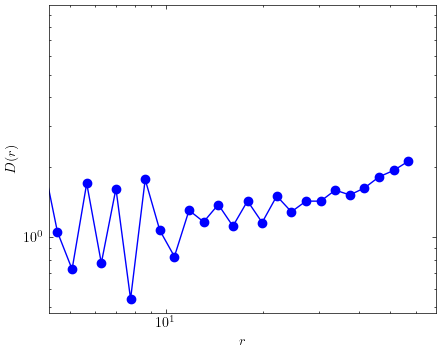

In [114]:
plt.style.use('science')
plt.figure(figsize=(5,4))
plt.loglog(r2d, D2d, marker='o', color='blue')
plt.xlabel("$r$")
plt.xlim(4.3,)
plt.ylabel("$D(r)$")
plt.savefig("2d_loglog.png")
plt.show()

In [ ]:
# 3D sim

def run_3d(N=60, p=0.0095, steps=10000, warmup=2000):
    grid = np.zeros((N, N, N), dtype=int)

    bin_edges = np.logspace(0, np.log10(N/2), 35)
    hist_accum = np.zeros(len(bin_edges) - 1)

    snapshots = 0

    for t in range(steps):

        grid = step_3d(grid, p)
        fires = np.argwhere(grid == FIRE)

        if t < warmup:
            continue

        hist_accum = accumulate_Dr_from_snapshot(fires, hist_accum, bin_edges, N)
        snapshots += 1

    r_vals = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    dr = np.diff(bin_edges)

    D_r = hist_accum / (dr * snapshots)

    return r_vals, D_r

r3d, D3d = run_3d()

In [110]:
D3d_corrected = D3d / (r3d**2)

log_r = np.log10(r3d)
log_D = np.log10(D3d_corrected)

valid = (D3d_corrected > 0) & np.isfinite(log_D)
fit_mask = valid & (r3d > 3) & (r3d < 15)

coeffs = np.polyfit(log_r[fit_mask], log_D[fit_mask], 1)

slope = coeffs[0]
Df_3d = slope + 3

print("Slope (3D) =", slope)
print("Df (3D) =", Df_3d)

Slope (3D) = -0.6488602076392069
Df (3D) = 2.351139792360793


/tmp/ipykernel_4498/1627020932.py:4: RuntimeWarning: divide by zero encountered in log10
  log_D = np.log10(D3d_corrected)


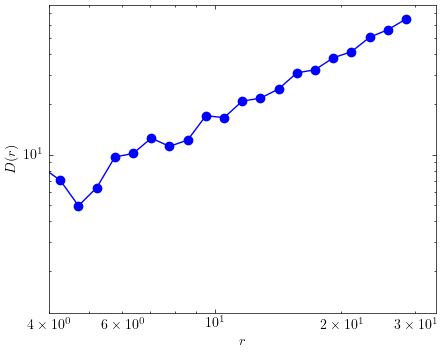

In [ ]:
plt.style.use('science')
plt.figure(figsize=(5,4))
plt.loglog(r3d, D3d, marker='o', color='blue')
plt.xlabel("$r$")
plt.xlim(4,)
plt.ylabel("$D(r)$")
plt.savefig('3d_loglog.png')
plt.show()